In [535]:
%load_ext autoreload
%autoreload 2
from DeepQLearning_env import *
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Question 11

In [506]:
trainer = DeepQTraining()
trainer.train(lambda e: 0.1, 0.5, self_training=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:37<00:00, 59.28it/s]


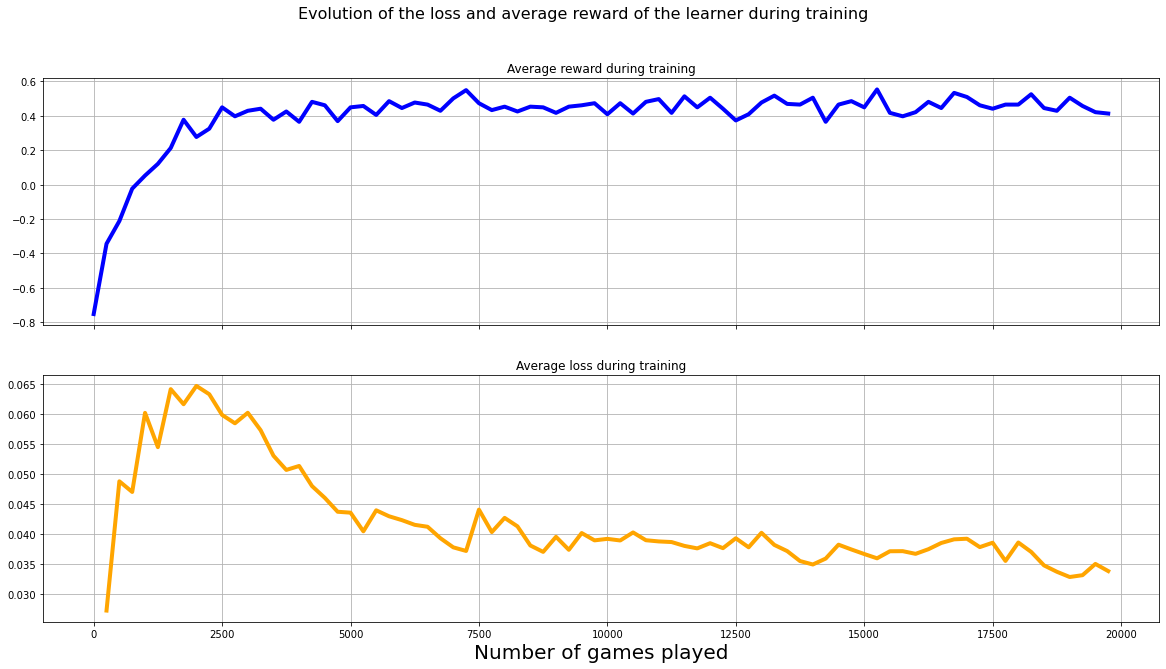

In [507]:
trainer.plot_avg_reward_loss_during_training()

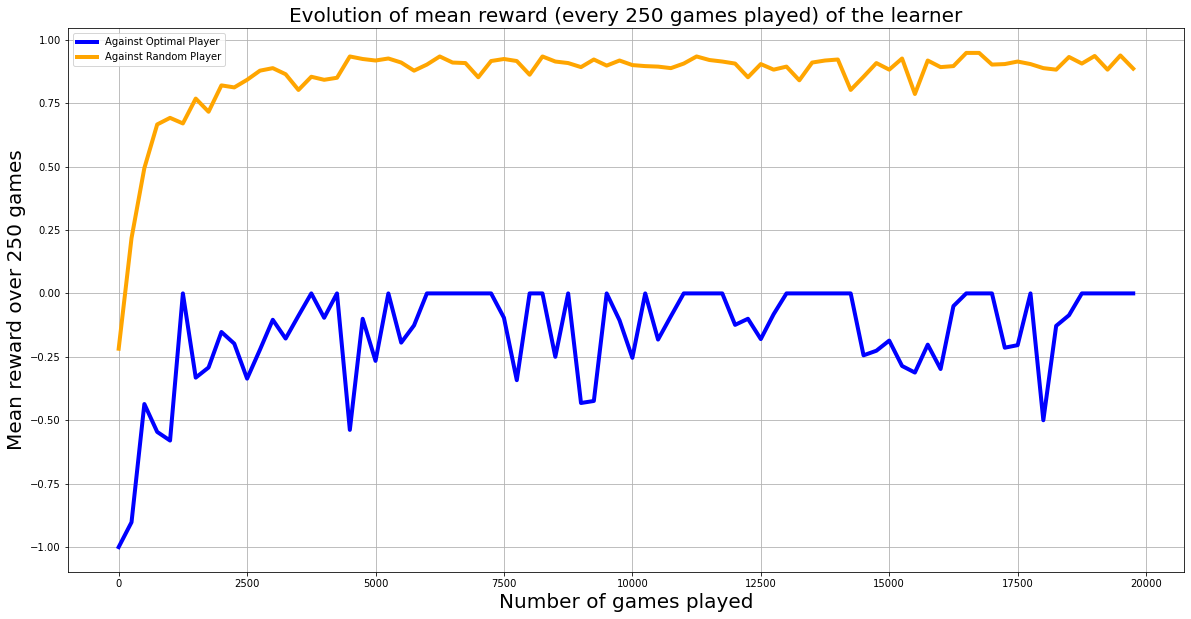

In [509]:
trainer.plot_mopt_mrng_during_training()

### Question 12

In [510]:
trainer2 = DeepQTraining(buffer_size=1, batch_size=1)
trainer2.train(lambda e: 0.1, 0.5, self_training=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:05<00:00, 65.52it/s]


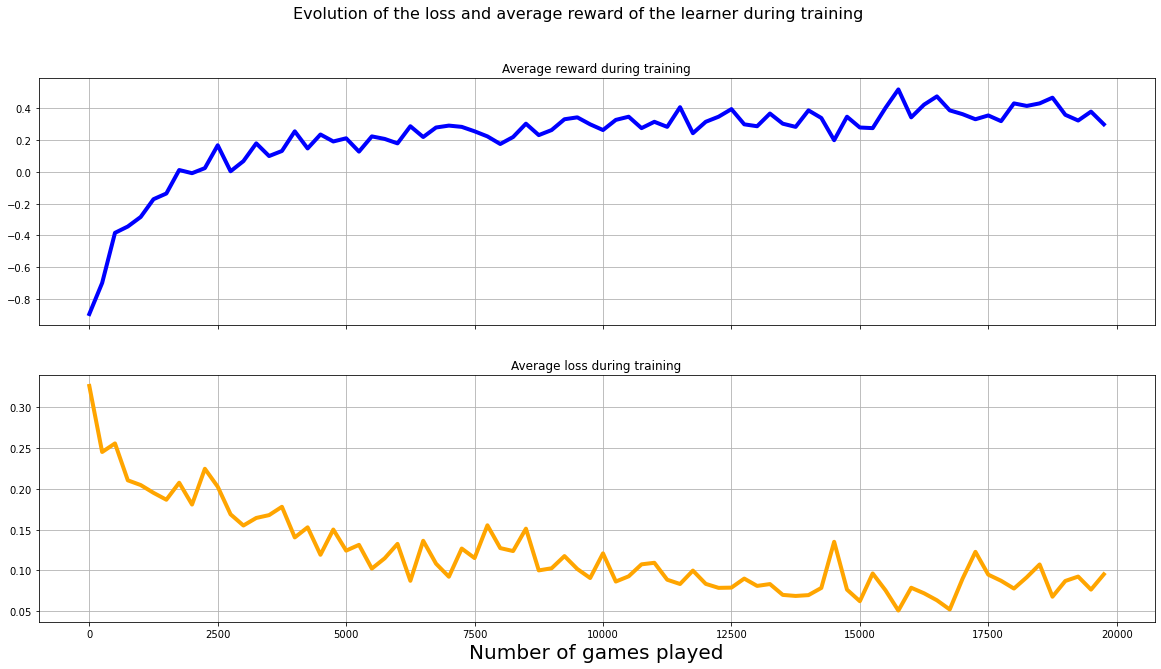

In [511]:
trainer2.plot_avg_reward_loss_during_training()

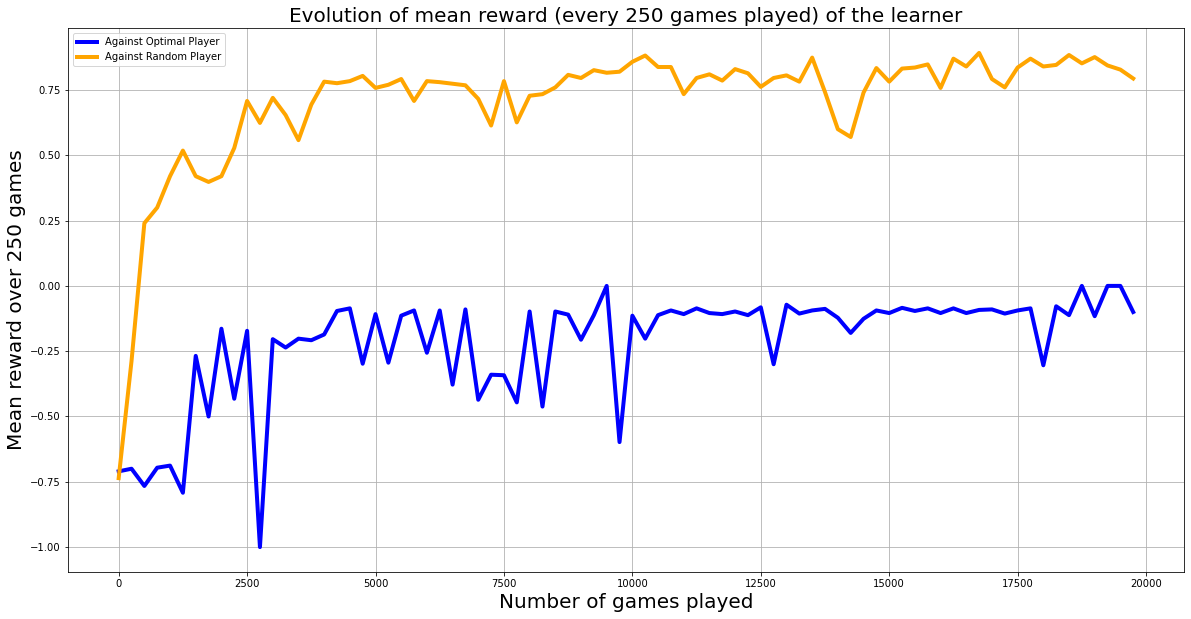

In [512]:
trainer2.plot_mopt_mrng_during_training()

### Question 13

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [14:44<00:00, 22.60it/s]


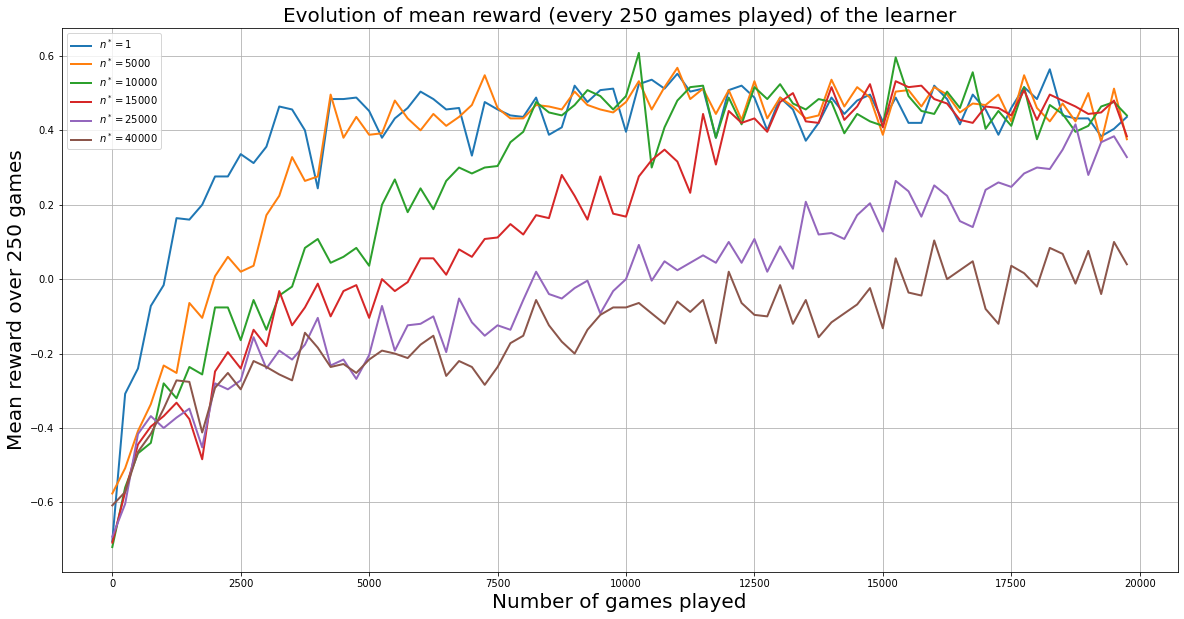

In [528]:
n_stars = [1, 5000, 10000, 15000, 25000, 40000]
epsilon_min = 0.1
epsilon_max = 0.8

values = []
values_mopt_mrng = []
names = []
epochs = 0
avg_step = 0

for n_star in n_stars:
    epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star))
    training2 = DeepQTraining()
    training2.train(epsilon_greedy_policy, 0.5, self_training=False)
    epochs = training2.epoch
    avg_step = training2.AVG_STEP
    
    values.append(training2.avg_reward)
    values_mopt_mrng.append([training2.score_test_opt, training2.score_test_rng])
    names.append(f"$n^*=${n_star}")
    
plots_several_trainings(values, names, avg_step, epochs)

### Question 14

In [529]:
# Part 2.1.2

n_star_best = 5000

epsilon_opts = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star_best))

values = []
values_mopt_mrng = []
names = []
epochs = 0
avg_step = 0

for epsilon_opt in epsilon_opts:
    training2 = DeepQTraining()
    training2.train(epsilon_greedy_policy, epsilon_opt, self_training=False)
    epochs = training2.epoch
    avg_step = training2.AVG_STEP
    
    values.append(training2.avg_reward)
    values_mopt_mrng.append([training2.score_test_opt, training2.score_test_rng])
    names.append(f"epsilon_opt={epsilon_opt}")
    
plots_several_trainings(values, names, avg_step, epochs)

  2%|████▌                                                                                                                                                                                | 499/20000 [00:08<05:41, 57.12it/s]


KeyboardInterrupt: 

### Question 15

In [486]:
(max_Mrnd, max_Mopt), (best_eps_rnd, best_eps_opt) = get_max_Mopt_Mrng_for_epsilon(values_mopt_mrng,epsilon_opts, "epsilon-opt")

## Self Learning
### Question 16

In [ ]:
# Part 2.1.2
epsilon_opts = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]

values = []
values_mopt_mrng = []
names = []
epochs = 0
avg_step = 0

for epsilon_opt in epsilon_opts:
    training2 = DeepQTraining()
    training2.train(lambda ep: epsilon_opt, epsilon_opt, self_training=True)
    epochs = training2.epoch
    avg_step = training2.AVG_STEP
    
    values.append(training2.avg_reward)
    values_mopt_mrng.append([training2.score_test_opt, training2.score_test_rng])
    names.append(f"epsilon_opt={epsilon_opt}")
    
plots_several_trainings(values, names, avg_step, epochs)

### Question 17

In [ ]:
n_stars = [1, 5000, 10000, 15000, 25000, 40000]
epsilon_min = 0.1
epsilon_max = 0.8

values = []
values_mopt_mrng = []
names = []
epochs = 0
avg_step = 0

for n_star in n_stars:
    epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star))
    training2 = DeepQTraining()
    training2.train(epsilon_greedy_policy, 0.5, self_training=True)
    epochs = training2.epoch
    avg_step = training2.avg_step
    
    values.append(training2.avg_reward)
    values_mopt_mrng.append([training2.score_test_opt, training2.score_test_rng])
    names.append(f"$n^*=${n_star}")
    
plots_several_trainings(values, names, avg_step, epochs)

### Quetion 18

In [ ]:
(max_Mrnd, max_Mopt), (best_eps_rnd, best_eps_opt) = get_max_Mopt_Mrng_for_epsilon(values_mopt_mrng, n_stars, "n_star")

### Question 19

In [516]:
# Same position as in Q-learning

states = ["---------", "XX-OO----", "X--O-X-O-"]
titles = ["Starting board", "Winning position", "Tactical move"]

# situation1: Starting board
"""
- - -
- - -
- - -
"""
# situation2: Winning position
""" 
X X -
O O -
- - -
"""

# situation3: Tactical move
""" 
X - -
O - X
- O -
"""

# Train the self-learners to obtain final Q-values
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000 # TODO change to the best n_start
training_heat = DeepQTraining()
training_heat.train(lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star)), 0.5, run_test=False, self_training=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:25<00:00, 97.11it/s]


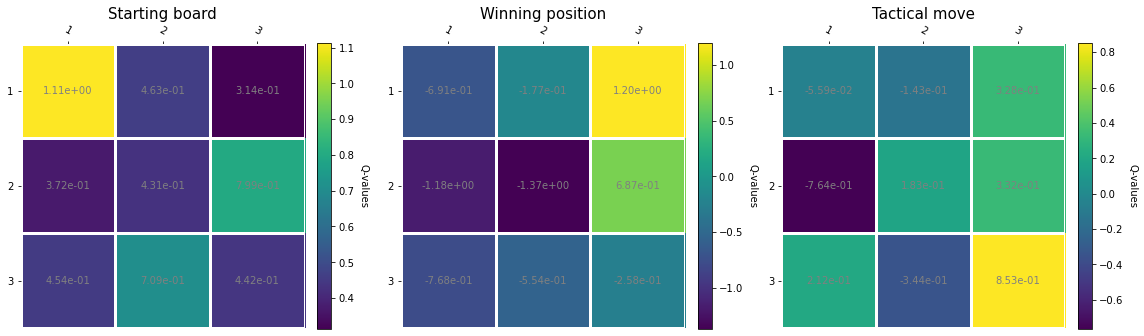

In [538]:
grids = [
    np.zeros((3,3)),
    np.array([[1,1,0],[-1,-1,0],[0,0,0]]),
    np.array([[1,0,0],[-1,0,1],[0,-1,0]]),
]

plot_game_heatmaps_deep_qlearning(states, training_heat.agent1,grids,["X","O","X"], titles)

## Comparison Q-Learning vs DeepQ-Learning

### Question 20

In [556]:
from QLearning_env import QPlayer, QTraining, get_state_best_Q

In [557]:
n_star_best = 15000
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star_best))
epsilon_opt = 0.0

training_q_opt = QTraining(epsilon_greedy_policy)
training_q_opt.train(epsilon_opt, run_test=True)

In [558]:
n_star_best = 15000
epsilon_min = 0.1
epsilon_max = 0.8
epsilon_greedy_policy = lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star_best))
epsilon_opt = 0.0

training_q_self = QTraining(epsilon_greedy_policy)
training_q_self.train(epsilon_opt, run_test=True, self_learning=True)

In [562]:
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000 # TODO change to the best n_start
training_deep_q_opt = DeepQTraining()
training_deep_q_opt.train(lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star)), 0.0, run_test=True, self_training=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:51<00:00, 56.88it/s]


In [563]:
epsilon_min = 0.1
epsilon_max = 0.8
n_star = 10000 # TODO change to the best n_start
training_deep_q_self = DeepQTraining()
training_deep_q_self.train(lambda ep: max(epsilon_min, epsilon_max*(1-ep/n_star)), 0.5, run_test=True, self_training=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:00<00:00, 55.45it/s]


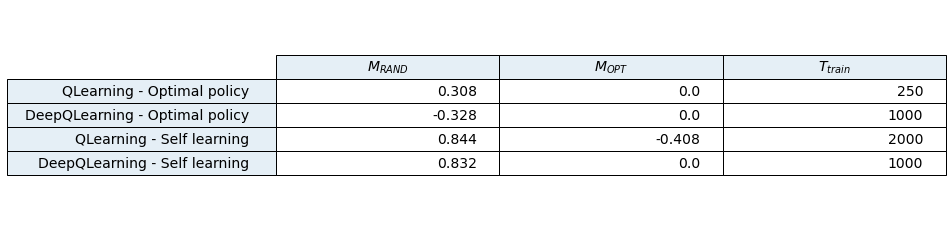

<Figure size 432x288 with 0 Axes>

In [575]:
get_performance_table(training_q_opt,training_deep_q_opt,training_q_self,training_deep_q_self)